# See get_bert_embeddings.ipynb in Colab Notebook folder
Due to computational limitations and Tensorflow version conflict this process was divided into 2 parts.

This notebook uses the saved dataframe with BERT embeddings.



In [10]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [1]:
import pickle

train_df = pickle.load(open('../Data/combined_train_bert_embeds.pkl', 'rb'))
test_df = pickle.load(open('../Data/combined_test_bert_embeds.pkl', 'rb'))

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
train_df.shape

(6401, 4)

In [4]:
test_df.shape

(398, 4)

In [5]:
xtrain, ytrain = train_df.embeds.values.tolist(), train_df.priority
xtest, ytest = test_df.embeds.values.tolist(), test_df.priority

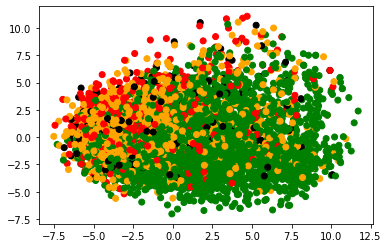

In [6]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

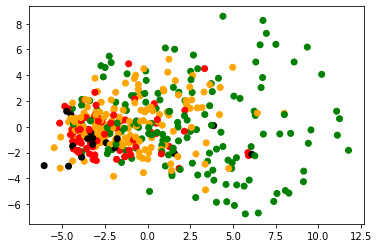

In [7]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [27]:
%%time

params = {'C': scipy.stats.expon(scale=10), 
          'gamma': scipy.stats.expon(scale=.1), 
          'kernel': ['rbf'], 
          'class_weight':['balanced'],
          'cache_size': [1024]}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=20,
                         verbose=2)


# params = [
#     {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'class_weight':['balanced']},
# ]

# clf = GridSearchCV(estimator=SVC(),
#                          param_grid=params,
#                          n_jobs=10,
#                          scoring='f1_macro',
#                          cv=5)

svc_searched_clf = clf.fit(xtrain, ytrain)


print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 18.8min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 59.5min finished


Best Params: {'C': 11.499481051968692, 'cache_size': 1024, 'class_weight': 'balanced', 'gamma': 0.0023511536715285965, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.5128280887643623 

SVC(C=11.499481051968692, cache_size=1024, class_weight='balanced',
    gamma=0.0023511536715285965) 

Wall time: 1h 43s


In [26]:
# pickle.dump(clf, open('./bert_svm_model/bert_svm_model.sav', 'wb'))
# clf = pickle.load(open('./doc2vec_svm_model/svm_model.sav', 'wb'))

In [28]:
predicted_priority = svc_searched_clf.predict(xtest)    
print_results(ytest, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.69      0.75      0.72       154
    escalate       0.63      0.71      0.67        17
       green       0.80      0.86      0.83       158
         red       0.60      0.35      0.44        69

    accuracy                           0.72       398
   macro avg       0.68      0.67      0.66       398
weighted avg       0.71      0.72      0.71       398


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.6091768445178896

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.90      0.85      0.88       240
       green       0.80      0.86      0.83       158

    accuracy                           0.86       398
   macro avg       0.85      0.86      0.85       398
weighted avg       0.86      0.86      0.86       398


----URGENT - 'red + escalate

In [22]:
test_df['prediction'] = predicted_priority
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 200

In [ ]:
test_df[test_df.priority != test_df.prediction][['text', 'priority', 'prediction']]